In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Alternating Least Squares (ALS) 
#### Reference: [Document](http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf)

We are familiar with the matrix factorization approaches used in Recommendation Systems, where we try to factorize the ratings matrix (user indices as rows, item indices as columns and ratings as values) into two matrices representing user and item embeddings with a number of latent factors. Our objective is to minimize the reconstruction error between ratings matrix and low-rank approximation of it. Some of the ways by which we can learn this matrix is with Gradient Descent or Singular Value Decomposition.

The loss/cost function in the case of Gradient Descent is given by:

\begin{equation}
\min _{X, Y} \sum_{r_{u i} \text { observed }}\left(r_{u i}-x_{u}^{\top} y_{i}\right)^{2}+\lambda\left(\sum_{u}\left\|x_{u}\right\|^{2}+\sum_{i}\left\|y_{i}\right\|^{2}\right)
\end{equation}

However, the above cost function is non-convex because of the term: 
\begin{equation}
x_{u}^{T} y_{i}
\end{equation}

And so, Gradient Descent might get stuck in local optima. However, if we fix $X$ and optimize for $Y$ only (and vice versa), then the function becomes convex. So our approach will be to fix X first and optimize for Y, and then fix Y and optimize for X. Hence, the term **Alternating Least Squares (ALS)**.

### Algorithm:

Initialize $X, Y$
repeat
for $u=1 \ldots n$ do
$$
x_{u}=\left(\sum_{r_{u i} \in r_{u *}} y_{i} y_{i}^{\top}+\lambda I_{k}\right)^{-1} \sum_{r_{u i} \in r_{u *}} r_{u i} y_{i}
$$
end for
for $i=1 \ldots m$ do
$$
y_{i}=\left(\sum_{r_{u i} \in r_{* i}} x_{u} x_{u}^{\top}+\lambda I_{k}\right)^{-1} \sum_{r_{u i} \in r_{* i}} r_{u i} x_{u}
$$
end for
until convergence

### Limitation

Computing the dot product between $X$ and $Y$ is costly with computational cost $O(nmk)$ where: 
1. $n$ stands for number of users
2. $m$ stands for number of movies
3. $k$ stands for number of latent factors

In [ ]:
# # download ML1M dataset
# !wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip

In [2]:
# preprocessing movies data
with open('ml-1m/movies.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
movies_df = pd.DataFrame(data, columns = ['movieID','title','genres'])
movies_df['movieID'] = movies_df['movieID'].astype('int')

In [3]:
# preprocessing ratings data
with open('ml-1m/ratings.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
ratings_df = pd.DataFrame(data, columns = ['userID','movieID','rating','timestamp'])
ratings_df[['userID','movieID','rating']] = ratings_df[['userID','movieID','rating']].astype('int')

In [4]:
# splitting data into train and validation set 
ratings_df, ratings_val = train_test_split(ratings_df, test_size=0.1, random_state=42)
ratings_df.shape, ratings_val.shape

((900188, 4), (100021, 4))

In [5]:
def get_users_movies(df):
    users_list = df['userID'].unique().tolist()
    movies_list = df['movieID'].unique().tolist()
    n_users = len(users_list)
    n_movies = len(movies_list)
    
    print('Number of Users:', n_users) 
    print('Number of Movies:', n_movies)
    return users_list, movies_list, n_users, n_movies

def get_sample(df, users_list, movies_list, sample_user_pct, sample_movie_pct):
    n_users_sample = int(sample_user_pct * len(users_list))
    n_movies_sample = int(sample_movie_pct * len(movies_list))

    np.random.shuffle(users_list)
    np.random.shuffle(movies_list)

    sample_users = users_list[:n_users_sample]
    sample_movies = movies_list[:n_movies_sample]

    df = df[df.userID.isin(sample_users)]
    df = df[df.movieID.isin(sample_movies)]
    df = df.reset_index(drop=True)
    return df

In [6]:
users_list, movies_list, n_users, n_movies = get_users_movies(ratings_df)

sample_user_pct = 0.2
sample_movie_pct = 0.2
ratings_df = get_sample(ratings_df, users_list, movies_list, sample_user_pct, sample_movie_pct)
print('\nSample: ')
users_list, movies_list, n_users, n_movies = get_users_movies(ratings_df)

Number of Users: 6040
Number of Movies: 3694

Sample: 
Number of Users: 1208
Number of Movies: 711


In [7]:
# relabelling userIDs
userID2idx = dict(zip(users_list, range(n_users)))
idx2userID = {v:k for k, v in userID2idx.items()}
ratings_df['userID'].replace(userID2idx, inplace=True)

# relabelling movieIDs
movieID2idx = dict(zip(movies_list, range(n_movies)))
idx2movieID = {v:k for k, v in movieID2idx.items()}
movieID2name = dict(zip(movies_df['movieID'].values, movies_df['title'].values))
ratings_df['movieID'].replace(movieID2idx, inplace=True)

In [8]:
def get_ratings_mat(ratings_df):
    # mapping users to their rated movies
    interaction_dict = dict(ratings_df.groupby('userID')['movieID'].apply(lambda x: np.array(x)))
    # mapping users to their ratings
    ratings_dict = dict(ratings_df.groupby('userID')['rating'].apply(lambda x: np.array(x)))
    ratings_mat = np.zeros((n_users, n_movies), dtype='int')
    
    for userID, movieIDs in interaction_dict.items():        
        # highlight rating
        ratings_mat[userID, movieIDs] = ratings_dict[userID]
    return ratings_mat

In [9]:
lamda = 0.5
n_latent = 50
eps = 1E-1

In [10]:
def loss_fn(P, Q, R, lamda):
    return np.sum(np.square(R - P.T @ Q)) + lamda * (np.sum(np.square(P)) + np.sum(np.square(Q)))

def run_iteration(P, Q, lamda):
    # keeping movie embeddings constant
    for u in range(n_users):
        rated_movie_idxs = np.nonzero(R[u, :])[0]
        A = sum(map(lambda x: np.outer(Q[:, x], Q[:, x]), rated_movie_idxs)) + lamda * np.identity(n_latent)
        B = sum(map(lambda x: R[u, x] * Q[:, x], rated_movie_idxs))
        P[:, u] = np.linalg.inv(A) @ B

    # keeping user embeddings constant
    for v in range(n_movies):
        rated_users_idxs = np.nonzero(R[:, v])[0]
        A = sum(map(lambda x: np.outer(P[:, x], P[:, x]), rated_users_idxs)) + lamda * np.identity(n_latent)
        B = sum(map(lambda x: R[x, v] * P[:, x], rated_users_idxs))
        Q[:, v] = np.linalg.inv(A) @ B
    return P, Q

In [11]:
R = get_ratings_mat(ratings_df)
assert R.shape == (n_users, n_movies)

P_init = np.random.normal(size=(n_latent, n_users))
Q_init = np.random.normal(size=(n_latent, n_movies))

P = P_init
Q = Q_init
P_prev = P_init + 1
Q_prev = Q_init + 1
costs = []
n_iter = 0

while (np.linalg.norm(P-P_prev) > eps) and (np.linalg.norm(Q-Q_prev) > eps):
    P_prev = P.copy()
    Q_prev = Q.copy()
    P, Q = run_iteration(P, Q, lamda)
    cost = loss_fn(P, Q, R, lamda)
    costs.append(cost)
    n_iter += 1

    if n_iter % 10 == 0:
        print(f'Iteration: {n_iter} | Cost: {cost.round(2)}')

Iteration: 10 | Cost: 5030677.18
Iteration: 20 | Cost: 5141733.99
Iteration: 30 | Cost: 5168718.68
Iteration: 40 | Cost: 5168777.58
Iteration: 50 | Cost: 5162455.88
Iteration: 60 | Cost: 5156074.56
Iteration: 70 | Cost: 5150138.91
Iteration: 80 | Cost: 5145180.77
Iteration: 90 | Cost: 5141126.37
Iteration: 100 | Cost: 5137608.07
Iteration: 110 | Cost: 5134618.17
Iteration: 120 | Cost: 5132297.83
Iteration: 130 | Cost: 5130666.69
Iteration: 140 | Cost: 5129587.13
Iteration: 150 | Cost: 5128857.91
Iteration: 160 | Cost: 5128317.64
Iteration: 170 | Cost: 5127889.66
Iteration: 180 | Cost: 5127565.54
Iteration: 190 | Cost: 5127365.7
Iteration: 200 | Cost: 5127310.63
Iteration: 210 | Cost: 5127409.37
Iteration: 220 | Cost: 5127657.83
Iteration: 230 | Cost: 5128041.46
Iteration: 240 | Cost: 5128540.57
Iteration: 250 | Cost: 5129135.64
Iteration: 260 | Cost: 5129808.51
Iteration: 270 | Cost: 5130539.2
Iteration: 280 | Cost: 5131301.56
Iteration: 290 | Cost: 5132061.81
Iteration: 300 | Cost: 51

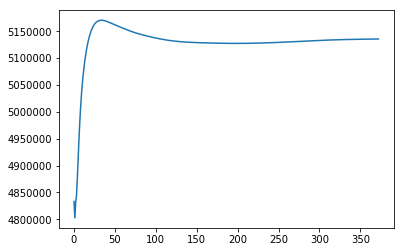

In [12]:
plt.plot(costs)
plt.show()

In [13]:
ratings_val['userID'].replace(userID2idx, inplace=True)
ratings_val['movieID'].replace(movieID2idx, inplace=True)

val_users = ratings_val['userID'].values
val_movies = ratings_val['movieID'].values
val_users = list(set(val_users).intersection(users_list))
val_movies = list(set(val_movies).intersection(movies_list))

ratings_val = ratings_val[ratings_val['userID'].isin(val_users) & ratings_val['movieID'].isin(val_movies)].reset_index(drop=True)

In [16]:
R_val = get_ratings_mat(ratings_val)
R_val = R_val[val_users][:, val_movies]
R_pred = P.T @ Q
R_pred = R_pred[val_users][:, val_movies]
assert R_val.shape == R_pred.shape